> # Imports

In [1]:
#Imports
import re

import unicodedata
import nltk
import nltk.sentiment
from wordcloud import WordCloud

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as wr
import env

import os
from sqlalchemy import text, create_engine


imports loaded successfully, awaiting commands...


1. Spam Data
    * Load the spam data set.
    * Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
    * Is there any overlap in the bigrams for the spam data and the ham data?
    * Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.
2. Explore the blog articles using the techniques discussed in the exploration lesson.

3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

## 1a. Load Spam Data

In [2]:
#Get SQL database url
url = wr.get_connection('spam_db')

In [3]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [4]:
#Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [5]:
#we can do that process with a join on a Series and not just a list
#we will do that for ham words, spam words, and all words
#we will pass our basic cleaning on top of that

ham_words = wr.clean(' '.join(df[df.label=="ham"]['text']))
spam_words = wr.clean(' '.join(df[df.label=="spam"]['text']))
all_words = wr.clean(' '.join(df['text']))

#look at lengths
len(all_words), len(spam_words), len(ham_words)

(50018, 12044, 37974)

In [6]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [7]:
#bring all back together into df
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['ham', 'spam', 'all']

word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [8]:
#making the bigrams
list(nltk.bigrams(ham_words)).value_counts(ascending=False).head(20).plot.barh(); #cannot do this on a list

AttributeError: 'list' object has no attribute 'value_counts'

In [127]:
#bigrams and save
top_20_ham_bigrams = pd.Series(nltk.bigrams(ham_words)).value_counts(ascending=False).head(20)
top_20_spam_bigrams = pd.Series(nltk.bigrams(spam_words)).value_counts(ascending=False).head(20)

top_20_ham_bigrams, top_20_spam_bigrams

((call, later)      52
 (ill, call)        48
 (let, know)        42
 (sorry, ill)       39
 (dont, know)       32
 (good, morning)    31
 (new, year)        30
 (take, care)       26
 (im, going)        24
 (ok, lor)          22
 (pls, send)        22
 (im, gonna)        20
 (happy, new)       19
 (good, night)      19
 (wat, time)        18
 (last, night)      18
 (hi, hi)           18
 (great, day)       17
 (nice, day)        15
 (dont, want)       15
 dtype: int64,
 (please, call)          44
 (customer, service)     27
 (po, box)               24
 (a1000, cash)           23
 (guaranteed, call)      23
 (prize, guaranteed)     22
 (every, week)           19
 (await, collection)     19
 (chance, win)           19
 (selected, receive)     19
 (send, stop)            19
 (land, line)            18
 (urgent, mobile)        18
 (claim, call)           17
 (valid, 12hrs)          17
 (call, 08000930705)     16
 (account, statement)    16
 (prize, claim)          16
 (sae, tc)           

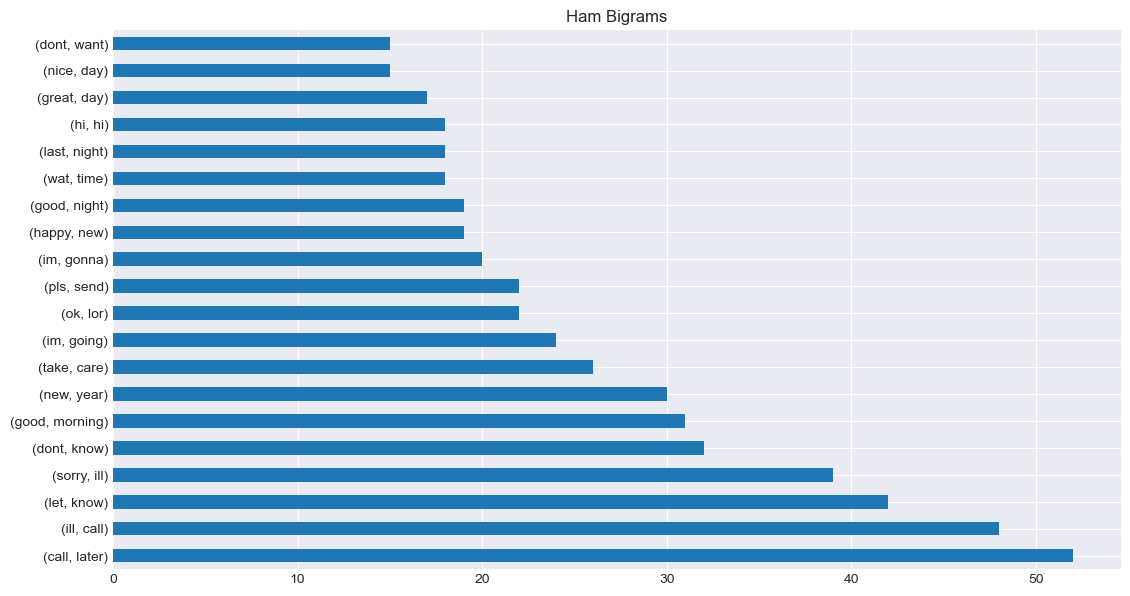

In [128]:
#turn ham_words list to a series to plot
top_20_ham_bigrams.plot.barh()
plt.title('Ham Bigrams')
plt.show()

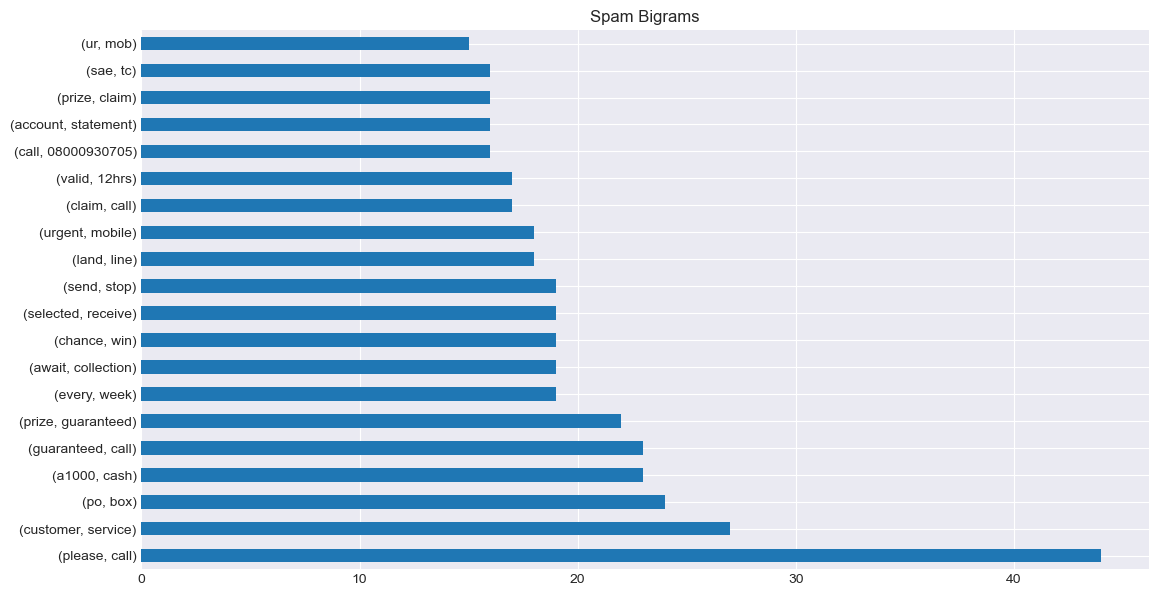

In [129]:
#turn spam_words list to a series to plot
top_20_spam_bigrams.plot.barh()
plt.title('Spam Bigrams')
plt.show()

> The spam bigrams reference calling or contacting somehow and the ham bigrams are definitely more personal and with softer natural language

In [130]:
#sending spam grams {modified key name : frequency value}
{key[0] + " " + key[1]: value for key, value in top_20_spam_bigrams.to_dict().items()}

{'please call': 44,
 'customer service': 27,
 'po box': 24,
 'a1000 cash': 23,
 'guaranteed call': 23,
 'prize guaranteed': 22,
 'every week': 19,
 'await collection': 19,
 'chance win': 19,
 'selected receive': 19,
 'send stop': 19,
 'land line': 18,
 'urgent mobile': 18,
 'claim call': 17,
 'valid 12hrs': 17,
 'call 08000930705': 16,
 'account statement': 16,
 'prize claim': 16,
 'sae tc': 16,
 'ur mob': 15}

In [131]:
#sending ham grams {modified key name : frequency value}
{key[0] + " " + key[1]: value for key, value in top_20_ham_bigrams.to_dict().items()}

{'call later': 52,
 'ill call': 48,
 'let know': 42,
 'sorry ill': 39,
 'dont know': 32,
 'good morning': 31,
 'new year': 30,
 'take care': 26,
 'im going': 24,
 'ok lor': 22,
 'pls send': 22,
 'im gonna': 20,
 'happy new': 19,
 'good night': 19,
 'wat time': 18,
 'last night': 18,
 'hi hi': 18,
 'great day': 17,
 'nice day': 15,
 'dont want': 15}

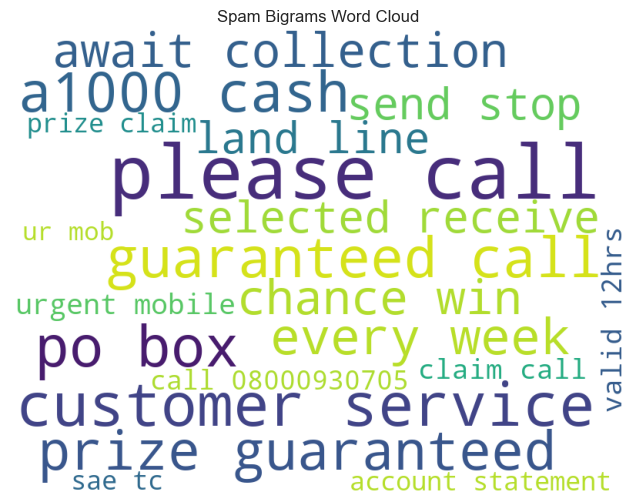

In [134]:
#creating the wordcloud and using it for bigrams!
spam_bigram_data = {key[0] + " " + key[1]: value for key, value in top_20_spam_bigrams.to_dict().items()}
spam_bigram_img = WordCloud(background_color='white', width=800,height=600).generate_from_frequencies(spam_bigram_data)

plt.figure(figsize=(10,6))
plt.imshow(spam_bigram_img)
plt.axis('off')
plt.title('Spam Bigrams Word Cloud')
plt.show()

In [145]:
def plot_bigrams(words):
    '''
    '''
    #creating the wordcloud and using it for bigrams!
    word_data = {key[0] + " " + key[1]: value for key, value in words.to_dict().items()}
    word_img = WordCloud(background_color='white', width=800,height=600).generate_from_frequencies(word_data)

    plt.figure(figsize=(10,6))
    plt.imshow(word_img)
    plt.axis('off')
    plt.suptitle('Word Map')
    plt.show()

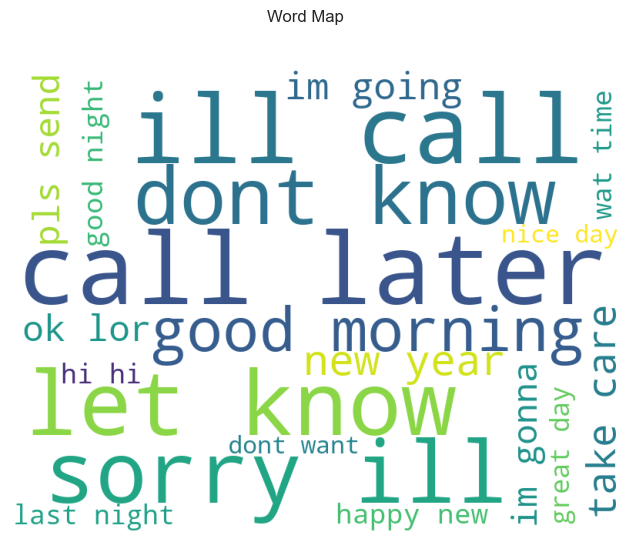

In [146]:
plot_bigrams(top_20_ham_bigrams)

## 1c. Is there any overlap in the bigrams for the spam data and the ham data?

> The only possible overlap I can see is to call...digging a little deeper

In [149]:
#create a dictionary of bigrams and freq for ham
ham_bigram_data = {key[0] + " " + key[1]: value for key, value in top_20_ham_bigrams.to_dict().items()}
ham_bigram_data

{'call later': 52,
 'ill call': 48,
 'let know': 42,
 'sorry ill': 39,
 'dont know': 32,
 'good morning': 31,
 'new year': 30,
 'take care': 26,
 'im going': 24,
 'ok lor': 22,
 'pls send': 22,
 'im gonna': 20,
 'happy new': 19,
 'good night': 19,
 'wat time': 18,
 'last night': 18,
 'hi hi': 18,
 'great day': 17,
 'nice day': 15,
 'dont want': 15}

In [152]:
#there are no overlapping words
overlap_list = [bigram for bigram in top_20_spam_bigrams.keys() if bigram in top_20_ham_bigrams.keys()]
overlap_list

[]

## 1d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

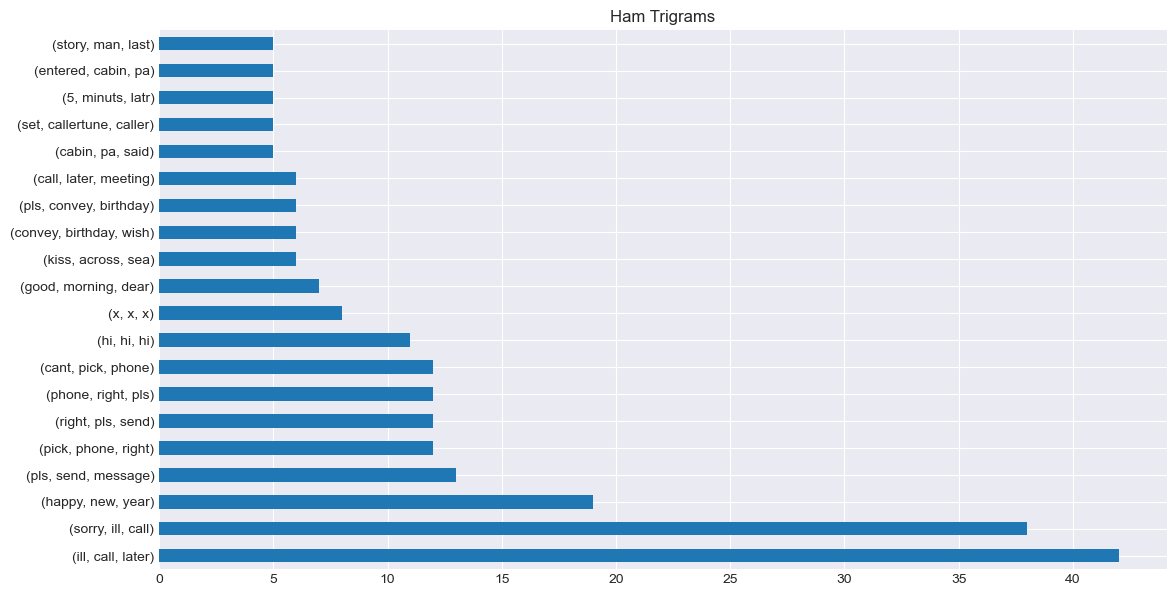

In [160]:
#turn ham_words list to a series to plot
ham_trigram_data = pd.Series(nltk.ngrams(ham_words, n=3)).value_counts(ascending=False).head(20)
ham_trigram_data.plot.barh()
plt.title('Ham Trigrams')
plt.show()

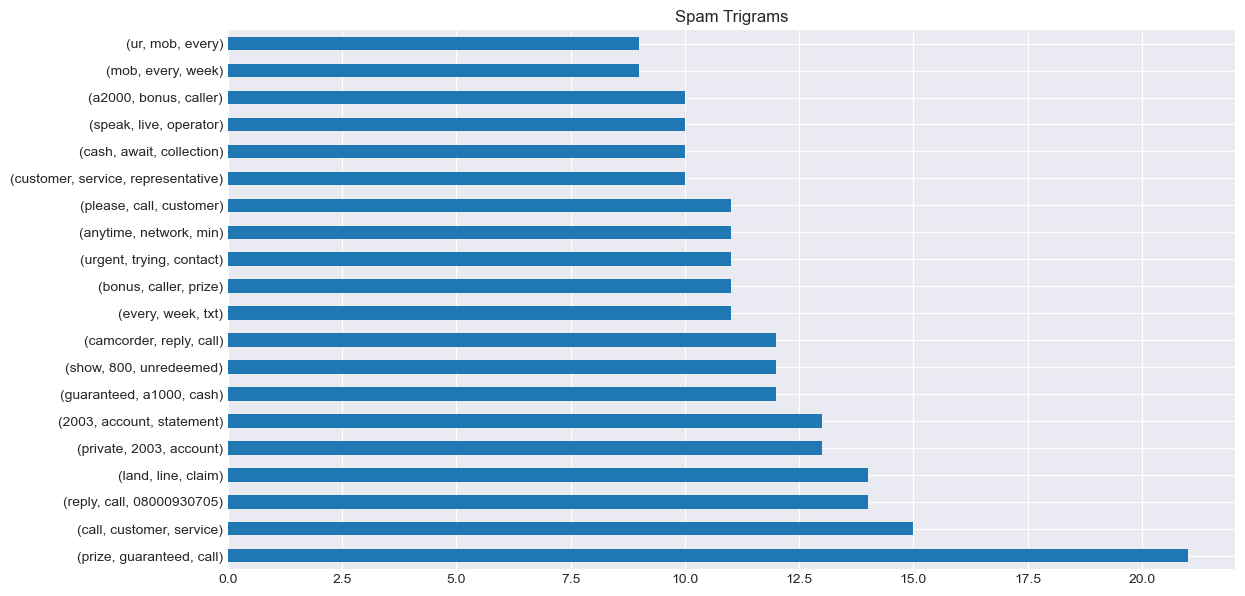

In [158]:
#turn spam_words list to a series to plot
spam_trigram_data = pd.Series(nltk.ngrams(spam_words, n=3)).value_counts(ascending=False).head(20)
spam_trigram_data.plot.barh()
plt.title('Spam Trigrams')
plt.show()

In [164]:
# #creating new list comprehension for tri-grams
# spam_trigram_words = {key[0]+ ' '+ key[1]+' '+ key[2]: value for key, value in spam_trigram_data.to_dict().items()}
# spam_trigram_img = WordCloud(background_color='white', width=800,height=600).generate_from_frequencies(spam_trigram_words)

# plt.figure(figsize=(10,6))
# plt.imshow(spam_trigram_img)
# plt.axis('off')
# plt.suptitle('Word Map')
# plt.show()

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [13]:
#get blogs
blogs = wr.get_blog_articles()
blogs

[{'title': 'Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa',
  'link': 'https://codeup.com/featured/apida-heritage-month/',
  'date_published': 'May 24, 2023',
  'content': ' May is traditionally known as Asian American and Pacific Islander (AAPI) Heritage Month. This month we celebrate the history and contributions made possible by our AAPI friends, family, and community. We also examine our level of support and seek opportunities to better understand the AAPI community.  In an effort to address real concerns and experiences, we sat down with Arbeena Thapa, one of Codeup’s Financial Aid and Enrollment Managers. Arbeena identifies as Nepali American and Desi. Arbeena’s parents immigrated to Texas in 1988 for better employment and educational opportunities. Arbeena’s older sister was five when they made the move to the US. Arbeena was born later, becoming the first in her family to be a US citizen. At Codeup we take our efforts at inclusivity very

In [14]:
#turn to a df
bdf = pd.DataFrame(blogs)
bdf.head(1)

,title,link,date_published,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,https://codeup.com/featured/apida-heritage-month/,"May 24, 2023",May is traditionally known as Asian American ...


In [15]:
#renaming some columns
bdf = bdf.rename(columns={'content':'original'}).drop(columns={'link','date_published'})

In [16]:
#clean the data using function
df = wr.clean_df(bdf)
df.head()

,title,original,clean,stem,lemma
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American ...,may traditionally known asian american pacific...,may tradit known asian american pacif island a...,may traditionally known asian american pacific...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena...,women tech panelist spotlight magdalena rahn c...,women tech panelist spotlight magdalena rahn c...,woman tech panelist spotlight magdalena rahn c...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Ro...,women tech panelist spotlight rachel robbinsma...,women tech panelist spotlight rachel robbinsma...,woman tech panelist spotlight rachel robbinsma...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mel...,women tech panelist spotlight sarah mellor cod...,women tech panelist spotlight sarah mellor cod...,woman tech panelist spotlight sarah mellor cod...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine...,women tech panelist spotlight madeleine capper...,women tech panelist spotlight madelein capper ...,woman tech panelist spotlight madeleine capper...


In [17]:
#drop some unneccesary columns for exploration
dfe = df[['title', 'lemma']]
dfe = dfe.rename(columns={'lemma' : 'content'})
dfe.head()

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,may traditionally known asian american pacific...
1,Women in tech: Panelist Spotlight – Magdalena ...,woman tech panelist spotlight magdalena rahn c...
2,Women in tech: Panelist Spotlight – Rachel Rob...,woman tech panelist spotlight rachel robbinsma...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,woman tech panelist spotlight sarah mellor cod...
4,Women in Tech: Panelist Spotlight – Madeleine ...,woman tech panelist spotlight madeleine capper...


In [18]:
#turning all columns into series using function
title_words = wr.clean(' '.join(dfe['title']))
content_words = wr.clean(' '.join(dfe['content']))

In [19]:
title_words[:5]

['spotlight', 'apida', 'voice', 'celebrating', 'heritage']

In [20]:
content_words[:5]

['may', 'traditionally', 'known', 'asian', 'american']

In [21]:
#make new all column
all_words = title_words + content_words
all_words

['spotlight',
 'apida',
 'voice',
 'celebrating',
 'heritage',
 'inspiring',
 'change',
 'ft',
 'arbeena',
 'thapa',
 'woman',
 'tech',
 'panelist',
 'spotlight',
 'magdalena',
 'rahn',
 'woman',
 'tech',
 'panelist',
 'spotlight',
 'rachel',
 'robbinsmayhill',
 'woman',
 'tech',
 'panelist',
 'spotlight',
 'sarah',
 'mellor',
 'woman',
 'tech',
 'panelist',
 'spotlight',
 'madeleine',
 'capper',
 'black',
 'excellence',
 'tech',
 'panelist',
 'spotlight',
 'wilmarie',
 'de',
 'la',
 'cruz',
 'mejia',
 'may',
 'traditionally',
 'known',
 'asian',
 'american',
 'pacific',
 'islander',
 'aapi',
 'heritage',
 'month',
 'month',
 'celebrate',
 'history',
 'contribution',
 'made',
 'possible',
 'aapi',
 'friend',
 'family',
 'community',
 'also',
 'examine',
 'level',
 'support',
 'seek',
 'opportunity',
 'better',
 'understand',
 'aapi',
 'community',
 'effort',
 'address',
 'real',
 'concern',
 'experience',
 'sat',
 'arbeena',
 'thapa',
 'one',
 'codeups',
 'financial',
 'aid',
 'enrollm

In [22]:
#now the words are in formats we can explore with
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

title_freq = pd.Series(title_words).value_counts()
content_freq = pd.Series(content_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [168]:
# top_20_blog_bigrams = 

In [169]:
# # create list of all_words
# plot_bigrams(top_20_blog_bigrams)

In [23]:
#put back into df format
# lets combine the 2 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([title_freq, content_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['title','content', 'all']

word_counts.head()

,title,content,all
spotlight,6,10,16
tech,5,15,20
panelist,5,11,16
woman,4,18,22
robbinsmayhill,1,2,3


In [24]:
# sort by 'title'
word_counts.sort_values('title', ascending=False).head(5)

,title,content,all
spotlight,6,10,16
panelist,5,11,16
tech,5,15,20
woman,4,18,22
rachel,1,11,12


In [25]:
# sort by 'content'
word_counts.sort_values('content', ascending=False).head(5)

,title,content,all
codeup,0,24,24
woman,4,18,22
data,0,17,17
tech,5,15,20
science,0,14,14


In [26]:
# we call nltk.sentiment.SentimentIntensityAnalyser()
# use polarity_scores from that object

sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [28]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score

dfe['title_sentiment'] = dfe['title'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
dfe['content_sentiment'] = dfe['content'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
dfe.head()

,title,content,title_sentiment,content_sentiment
0,Spotlight on APIDA Voices: Celebrating Heritag...,may traditionally known asian american pacific...,0.7579,0.9989
1,Women in tech: Panelist Spotlight – Magdalena ...,woman tech panelist spotlight magdalena rahn c...,0.0000,0.9689
2,Women in tech: Panelist Spotlight – Rachel Rob...,woman tech panelist spotlight rachel robbinsma...,0.0000,0.9954
3,Women in Tech: Panelist Spotlight – Sarah Mellor,woman tech panelist spotlight sarah mellor cod...,0.0000,0.9823
4,Women in Tech: Panelist Spotlight – Madeleine ...,woman tech panelist spotlight madeleine capper...,0.0000,0.9749


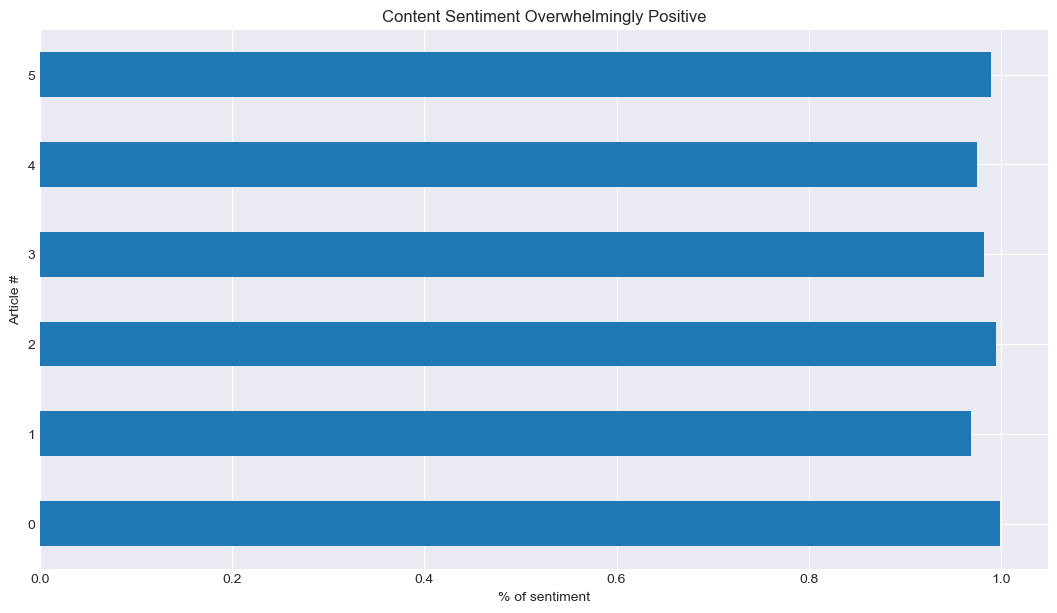

In [41]:
dfe.content_sentiment.plot.barh()
plt.title('Content Sentiment Overwhelmingly Positive')
plt.ylabel('Article #')
plt.xlabel('% of sentiment')
plt.show()

In [42]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

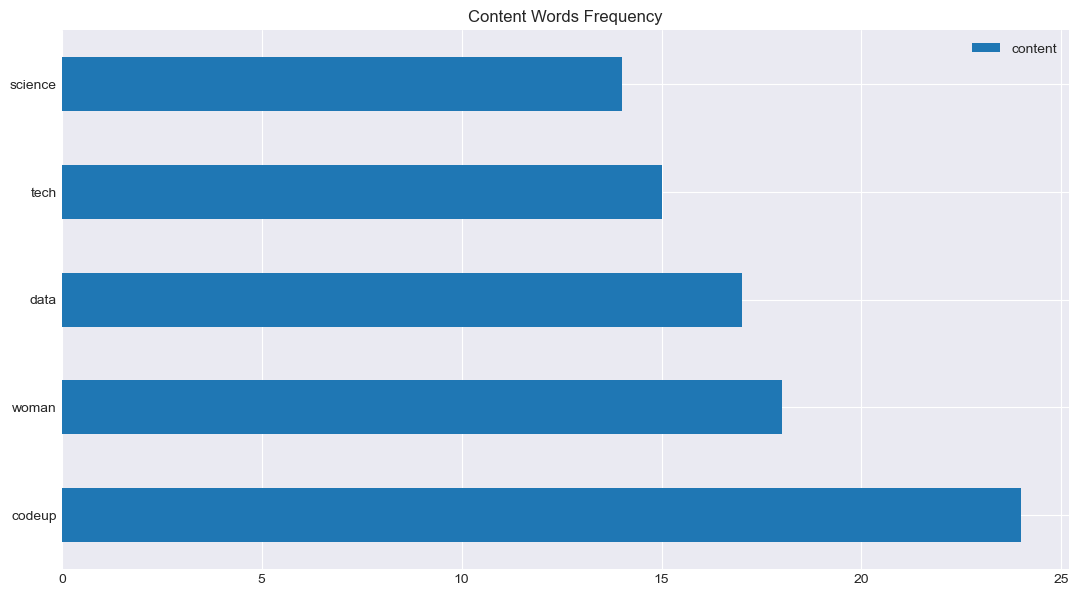

In [43]:
#visualizing the top 5 words sorted on content but only displaying the content column
word_counts.sort_values('content', ascending=False)[['content']].head(5).plot.barh()
plt.title('Content Words Frequency')
plt.show()

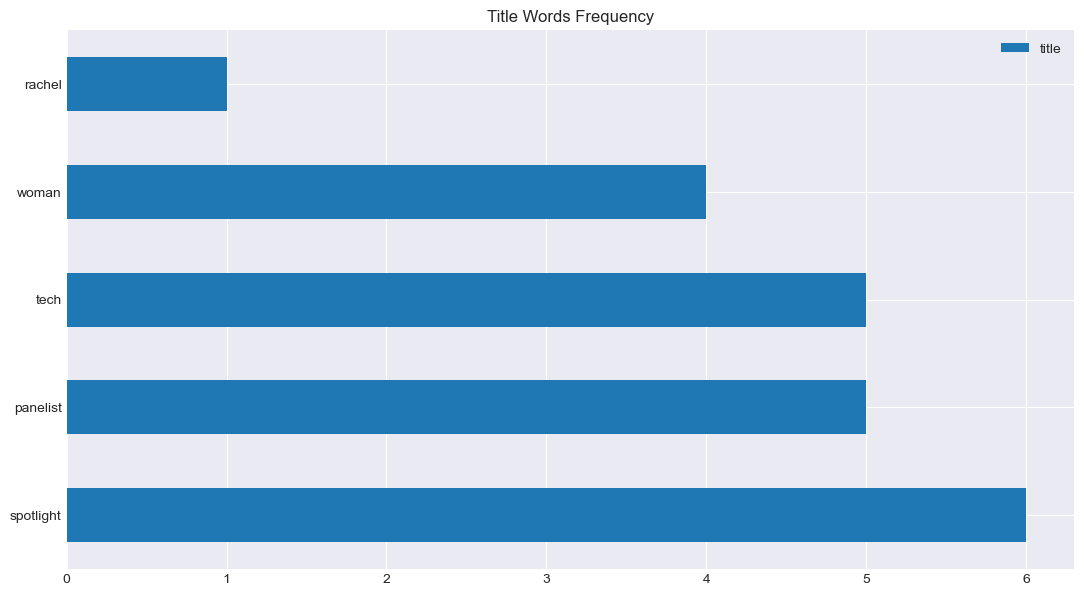

In [44]:
#visualizing the top 5 words sorted on title but only displaying the content column
word_counts.sort_values('title', ascending=False)[['title']].head(5).plot.barh()
plt.title('Title Words Frequency')
plt.show()

In [45]:
#applying a lambda to see the proportion values
word_counts.sort_values('content', ascending=False).head(20).apply(lambda row: row/row['all'], axis=1).round(2)

,title,content,all
codeup,0.00,1.00,1.0
woman,0.18,0.82,1.0
data,0.00,1.00,1.0
tech,0.25,0.75,1.0
science,0.00,1.00,1.0
asian,0.00,1.00,1.0
rachel,0.08,0.92,1.0
panelist,0.31,0.69,1.0
spotlight,0.38,0.62,1.0
career,0.00,1.00,1.0


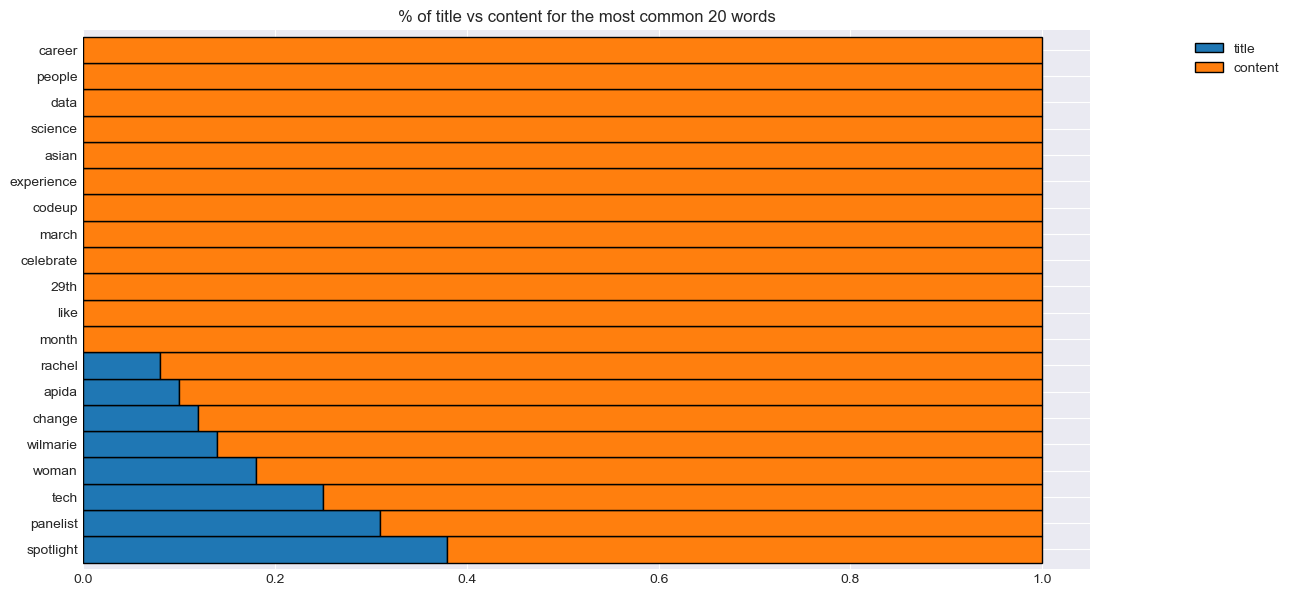

In [46]:
#visualizing the 20 most used words in proportion of words used in title and in content
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis=1).round(2)
 .drop(columns='all')
 .sort_values('content')
 .plot.barh(stacked=True, width=1, ec='black'))

plt.title('% of title vs content for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

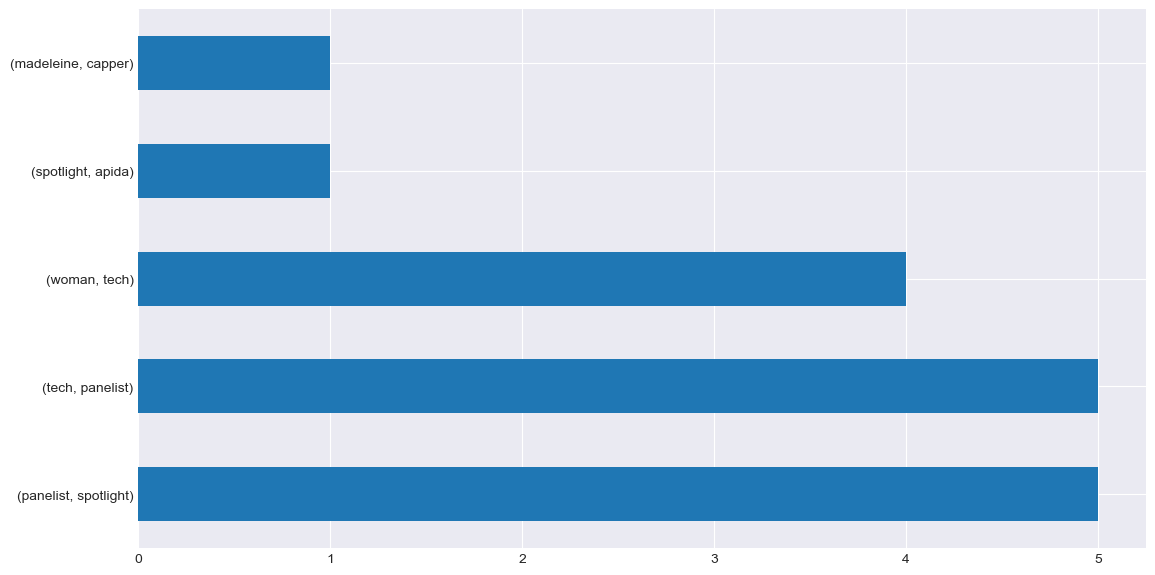

In [47]:
#looking at the bigrams for title words
pd.Series(nltk.bigrams(title_words)).value_counts(ascending=False).head(5).plot.barh();

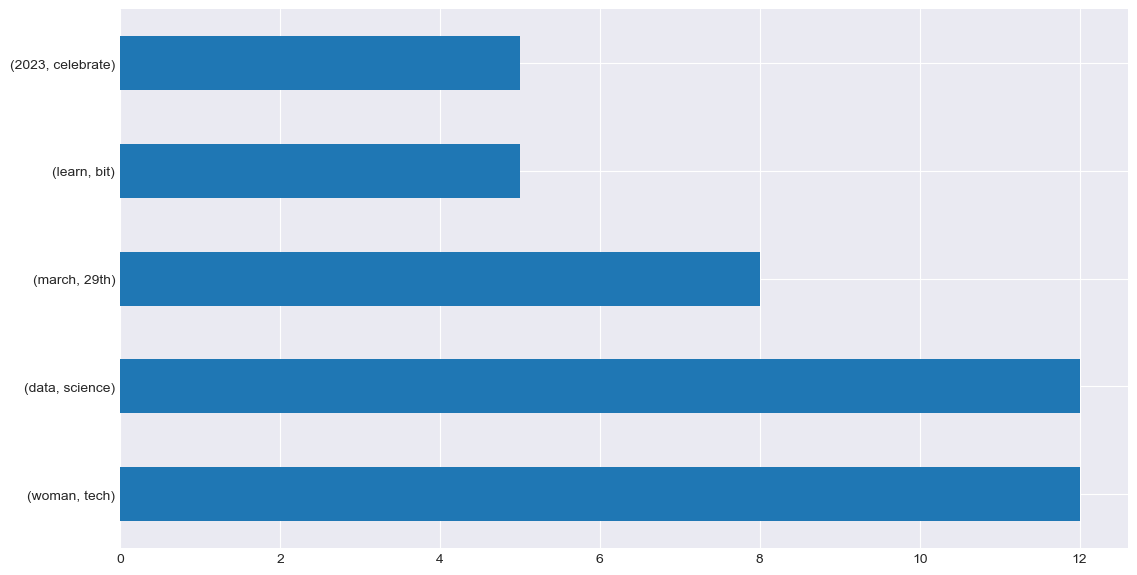

In [48]:
#looking at the bigrams for content words
pd.Series(nltk.bigrams(content_words)).value_counts(ascending=False).head(5).plot.barh();

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [49]:
#get blogs
articles = wr.get_news_articles()
articles

{'title': ['Was never interested in being LoP, give me party post: Ajit Pawar',
  "2 transgenders killed with stones & knives in Hyderabad's Daibagh",
  " I declare less than actual area while declaring properties: K'taka Deputy CM",
  'Experience hassle-free home interiors: HomeLane',
  'Asit Modi would pinch my cheeks, say inappropriate things about my looks: Actress in FIR',
  'US overestimated value of weapons sent to Ukraine by $6.2 bn due to error: Pentagon',
  "Iceland Cricket troll England with 'Bazball 0-1 Basic Common Sense' tweet",
  "TIME releases list of the world's 100 most influential companies",
  "'Cis' or 'cisgender' are considered slurs on Twitter: Elon Musk",
  "Int'l Yoga day a call to stand up for humankind: NY Mayor at UN HQ",
  'Woman tortured to death by relatives in UP, loud music played to cover up screams',
  'Urge brave sisters to lead way to bring peace to Manipur: Sonia',
  'Yoga event led by PM Modi in US creates Guinness World Record',
  'Thought kids a

In [50]:
#turn to a df
art = pd.DataFrame(articles)
art.head(1)

,title,content,category
0,"Was never interested in being LoP, give me par...",NCP leader Ajit Pawar has asked the party to r...,business


In [51]:
#renaming some columns
art = art.rename(columns={'content':'original'})

In [52]:
#clean the data using function
df = wr.clean_df(art)
df.head()

,title,original,category,clean,stem,lemma
0,"Was never interested in being LoP, give me par...",NCP leader Ajit Pawar has asked the party to r...,business,ncp leader ajit pawar asked party relieve resp...,ncp leader ajit pawar ask parti reliev respons...,ncp leader ajit pawar asked party relieve resp...
1,2 transgenders killed with stones & knives in ...,Two transgenders aged between 25 and 30 died a...,business,two transgenders aged 25 30 died attacked ston...,two transgend age 25 30 die attack stone knive...,two transgenders aged 25 30 died attacked ston...
2,I declare less than actual area while declari...,Karnataka Deputy CM DK Shivakumar while talkin...,business,karnataka deputy cm dk shivakumar talking paym...,karnataka deputi cm dk shivakumar talk payment...,karnataka deputy cm dk shivakumar talking paym...
3,Experience hassle-free home interiors: HomeLane,HomeLane invites you to discover the world of ...,business,homelane invites discover world personalized i...,homelan invit discov world person interior ' 4...,homelane invite discover world personalized in...
4,"Asit Modi would pinch my cheeks, say inappropr...",The details of FIR filed against 'Taarak Mehta...,business,details fir filed ' taarak mehta ka ooltah cha...,detail fir file ' taarak mehta ka ooltah chash...,detail fir filed ' taarak mehta ka ooltah chas...


In [53]:
#drop some unneccesary columns for exploration
dfe = df[['category', 'title', 'lemma']]
dfe = dfe.rename(columns={'lemma' : 'content'})
dfe.head()

,category,title,content
0,business,"Was never interested in being LoP, give me par...",ncp leader ajit pawar asked party relieve resp...
1,business,2 transgenders killed with stones & knives in ...,two transgenders aged 25 30 died attacked ston...
2,business,I declare less than actual area while declari...,karnataka deputy cm dk shivakumar talking paym...
3,business,Experience hassle-free home interiors: HomeLane,homelane invite discover world personalized in...
4,business,"Asit Modi would pinch my cheeks, say inappropr...",detail fir filed ' taarak mehta ka ooltah chas...


In [54]:
#turning all columns into series using function
category_words = wr.clean(' '.join(dfe['category']))
title_words = wr.clean(' '.join(dfe['title']))
content_words = wr.clean(' '.join(dfe['content']))

In [55]:
category_words[:5]

['business', 'business', 'business', 'business', 'business']

In [56]:
title_words[:5]

['never', 'interested', 'lop', 'give', 'party']

In [57]:
content_words[:5]

['ncp', 'leader', 'ajit', 'pawar', 'asked']

In [58]:
#make new all column
all_words = title_words + content_words
all_words

['never',
 'interested',
 'lop',
 'give',
 'party',
 'post',
 'ajit',
 'pawar',
 'transgenders',
 'killed',
 'stone',
 'knife',
 'hyderabad',
 'daibagh',
 'declare',
 'le',
 'actual',
 'area',
 'declaring',
 'property',
 'ktaka',
 'deputy',
 'cm',
 'experience',
 'hasslefree',
 'home',
 'interior',
 'homelane',
 'asit',
 'modi',
 'would',
 'pinch',
 'cheek',
 'say',
 'inappropriate',
 'thing',
 'look',
 'actress',
 'fir',
 'u',
 'overestimated',
 'value',
 'weapon',
 'sent',
 'ukraine',
 '62',
 'bn',
 'due',
 'error',
 'pentagon',
 'iceland',
 'cricket',
 'troll',
 'england',
 'bazball',
 '01',
 'basic',
 'common',
 'sense',
 'tweet',
 'time',
 'release',
 'list',
 'world',
 '100',
 'influential',
 'company',
 'ci',
 'cisgender',
 'considered',
 'slur',
 'twitter',
 'elon',
 'musk',
 'intl',
 'yoga',
 'day',
 'call',
 'stand',
 'humankind',
 'ny',
 'mayor',
 'un',
 'hq',
 'woman',
 'tortured',
 'death',
 'relative',
 'loud',
 'music',
 'played',
 'cover',
 'scream',
 'urge',
 'brave',


In [59]:
#now the words are in formats we can explore with
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

cat_freq = pd.Series(category_words).value_counts()
title_freq = pd.Series(title_words).value_counts()
content_freq = pd.Series(content_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [60]:
#put back into df format
# lets combine the 2 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([cat_freq, title_freq, content_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['category', 'title','content', 'all']

word_counts.head()

,category,title,content,all
business,25,0,0,0
sport,25,0,0,0
technology,25,0,0,0
entertainment,25,0,0,0
yoga,0,12,40,52


In [76]:
# we apply our clean function, apply len chained on it
# if we did not want to clean this before word count, we would want to do a split on it
dfe['word_count'] = (dfe['title'] + dfe['content']).apply(wr.clean).apply(len)
dfe['title_length'] = dfe['title'].apply(wr.clean).apply(len)
dfe

,category,title,content,title_sentiment,content_sentiment,word_count,title_length
0,business,"Was never interested in being LoP, give me par...",ncp leader ajit pawar asked party relieve resp...,0.1134,0.8378,39,8
1,business,2 transgenders killed with stones & knives in ...,two transgenders aged 25 30 died attacked ston...,-0.6705,-0.9231,38,6
2,business,I declare less than actual area while declari...,karnataka deputy cm dk shivakumar talking paym...,0.0000,0.1027,40,9
3,business,Experience hassle-free home interiors: HomeLane,homelane invite discover world personalized in...,0.0000,0.6705,43,5
4,business,"Asit Modi would pinch my cheeks, say inappropr...",detail fir filed ' taarak mehta ka ooltah chas...,0.0000,0.1280,45,11
...,...,...,...,...,...,...,...
95,entertainment,Video shows Army personnel performing underwat...,occasion ninth international yoga day indian a...,0.0000,0.5106,42,8
96,entertainment,"PM Modi's visit is to boost ties, not about Ru...",white house national security council coordina...,0.4019,0.6369,43,8
97,entertainment,German woman convicted of keeping Yazidi woman...,german woman convicted keeping yazidi woman sl...,0.0000,-0.9325,37,8
98,entertainment,Italians seeking surrogacy abroad may face up ...,italian lawmaker debating bill could make ille...,0.2023,-0.8481,44,10


In [61]:
# we call nltk.sentiment.SentimentIntensityAnalyser()
# use polarity_scores from that object

sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [62]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score

dfe['title_sentiment'] = dfe['title'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
dfe['content_sentiment'] = dfe['content'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
dfe

,category,title,content,title_sentiment,content_sentiment
0,business,"Was never interested in being LoP, give me par...",ncp leader ajit pawar asked party relieve resp...,0.1134,0.8378
1,business,2 transgenders killed with stones & knives in ...,two transgenders aged 25 30 died attacked ston...,-0.6705,-0.9231
2,business,I declare less than actual area while declari...,karnataka deputy cm dk shivakumar talking paym...,0.0000,0.1027
3,business,Experience hassle-free home interiors: HomeLane,homelane invite discover world personalized in...,0.0000,0.6705
4,business,"Asit Modi would pinch my cheeks, say inappropr...",detail fir filed ' taarak mehta ka ooltah chas...,0.0000,0.1280
...,...,...,...,...,...
95,entertainment,Video shows Army personnel performing underwat...,occasion ninth international yoga day indian a...,0.0000,0.5106
96,entertainment,"PM Modi's visit is to boost ties, not about Ru...",white house national security council coordina...,0.4019,0.6369
97,entertainment,German woman convicted of keeping Yazidi woman...,german woman convicted keeping yazidi woman sl...,0.0000,-0.9325
98,entertainment,Italians seeking surrogacy abroad may face up ...,italian lawmaker debating bill could make ille...,0.2023,-0.8481


In [77]:
dfe.head()

,category,title,content,title_sentiment,content_sentiment,word_count,title_length
0,business,"Was never interested in being LoP, give me par...",ncp leader ajit pawar asked party relieve resp...,0.1134,0.8378,39,8
1,business,2 transgenders killed with stones & knives in ...,two transgenders aged 25 30 died attacked ston...,-0.6705,-0.9231,38,6
2,business,I declare less than actual area while declari...,karnataka deputy cm dk shivakumar talking paym...,0.0000,0.1027,40,9
3,business,Experience hassle-free home interiors: HomeLane,homelane invite discover world personalized in...,0.0000,0.6705,43,5
4,business,"Asit Modi would pinch my cheeks, say inappropr...",detail fir filed ' taarak mehta ka ooltah chas...,0.0000,0.1280,45,11


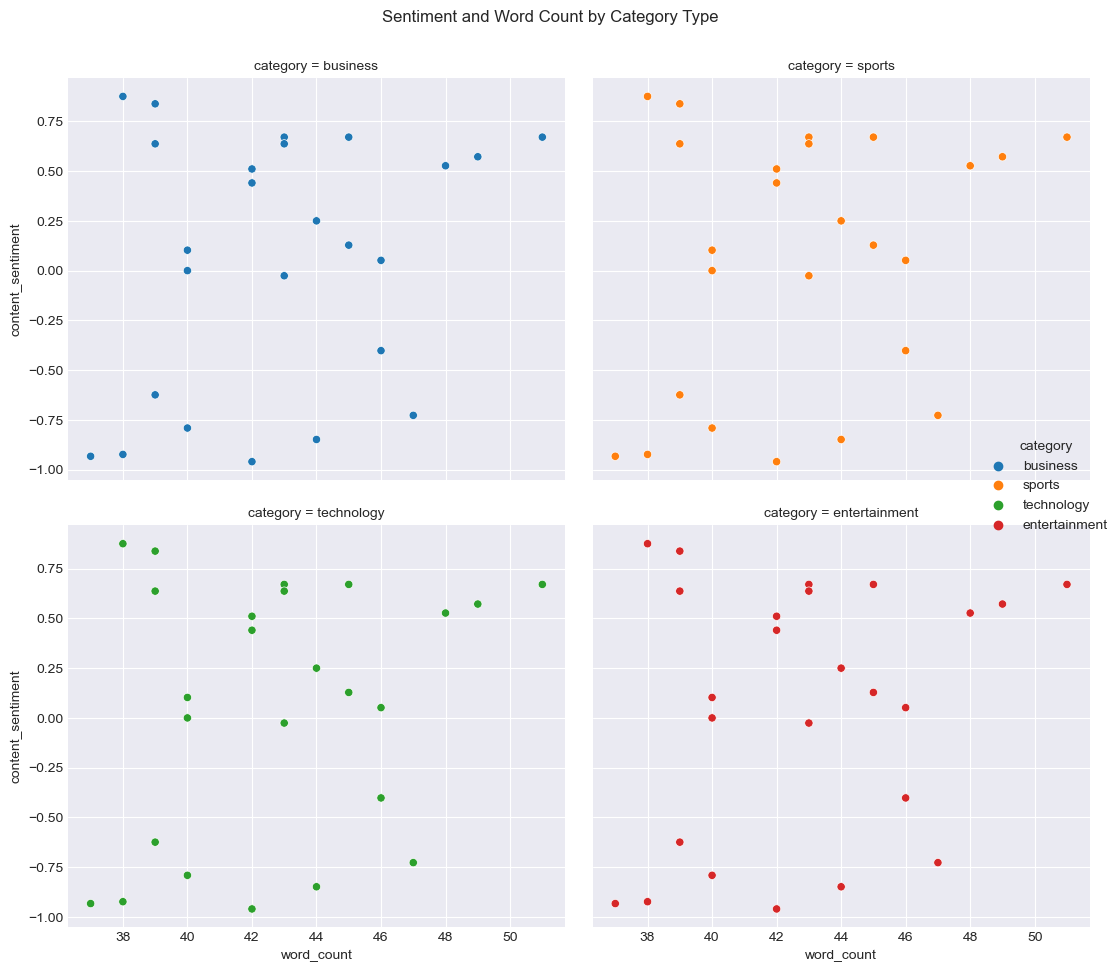

In [96]:
#plot content vs sentiment and hue by category
sns.relplot(data=dfe, x='word_count', y='content_sentiment', hue='category', col='category', col_wrap=2)
plt.suptitle('Sentiment and Word Count by Category Type')
plt.tight_layout(pad=2)
plt.show()

> Why does every category have the same word counts for each article?

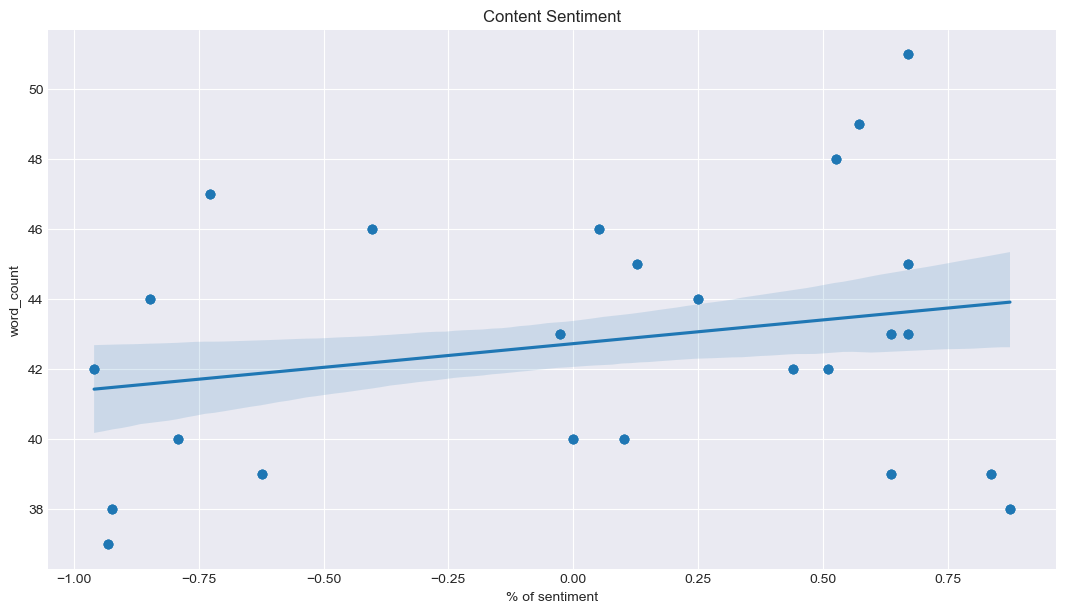

In [106]:
sns.regplot(data=dfe, x='content_sentiment', y='word_count')
plt.title('Content Sentiment')
plt.xlabel('% of sentiment')
plt.show()

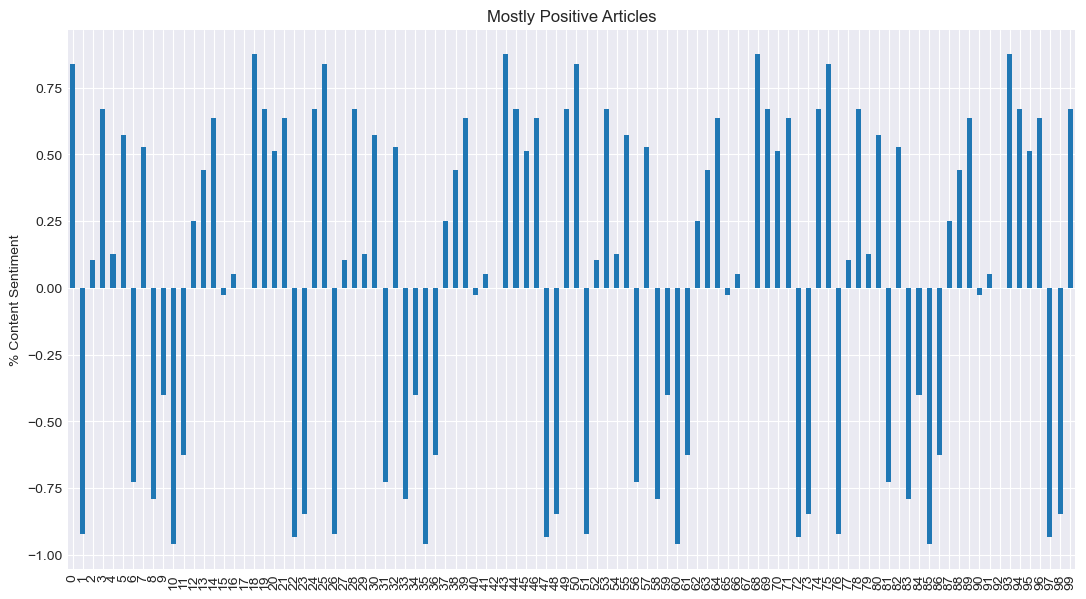

In [113]:
dfe.content_sentiment.plot(kind='bar')
plt.title('Mostly Positive Articles')
plt.ylabel('% Content Sentiment')
plt.show()

In [117]:
# sort by 'title'
word_counts.sort_values('title', ascending=False).head(5)

,category,title,content,all
yoga,0,12,40,52
woman,0,12,16,28
u,0,12,0,12
modi,0,8,16,24
start,0,8,8,16


In [116]:
# sort by 'content'
word_counts.sort_values('content', ascending=False).head(5)

,category,title,content,all
said,0,4,76,80
yoga,0,12,40,52
added,0,0,40,40
two,0,0,32,32
day,0,4,24,28


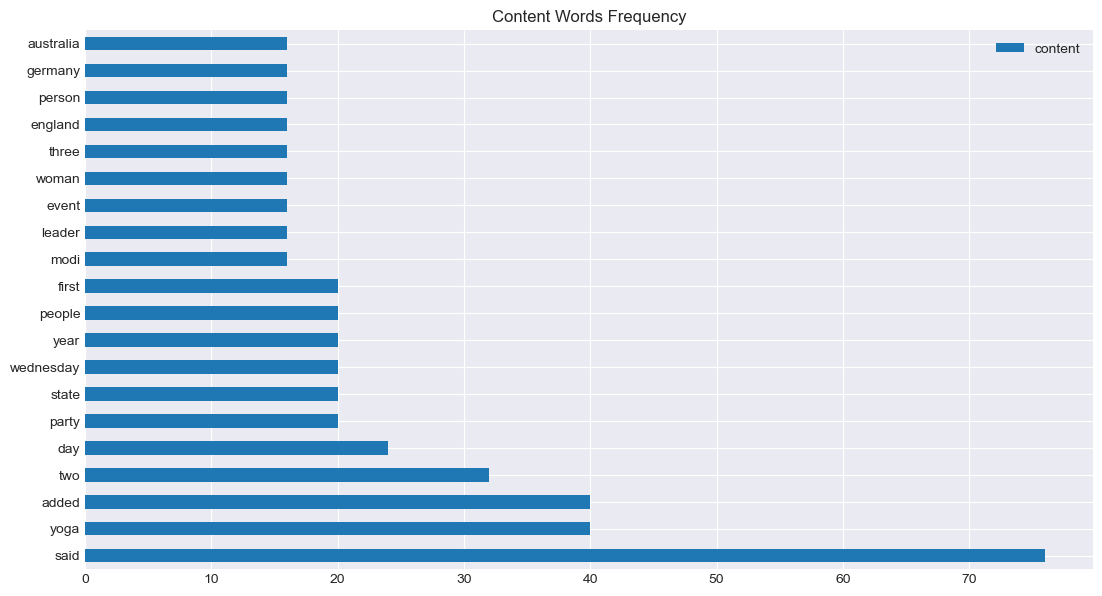

In [118]:
#visualizing the top 20 words sorted on content but only displaying the content column
word_counts.sort_values('content', ascending=False)[['content']].head(20).plot.barh()
plt.title('Content Words Frequency')
plt.show()

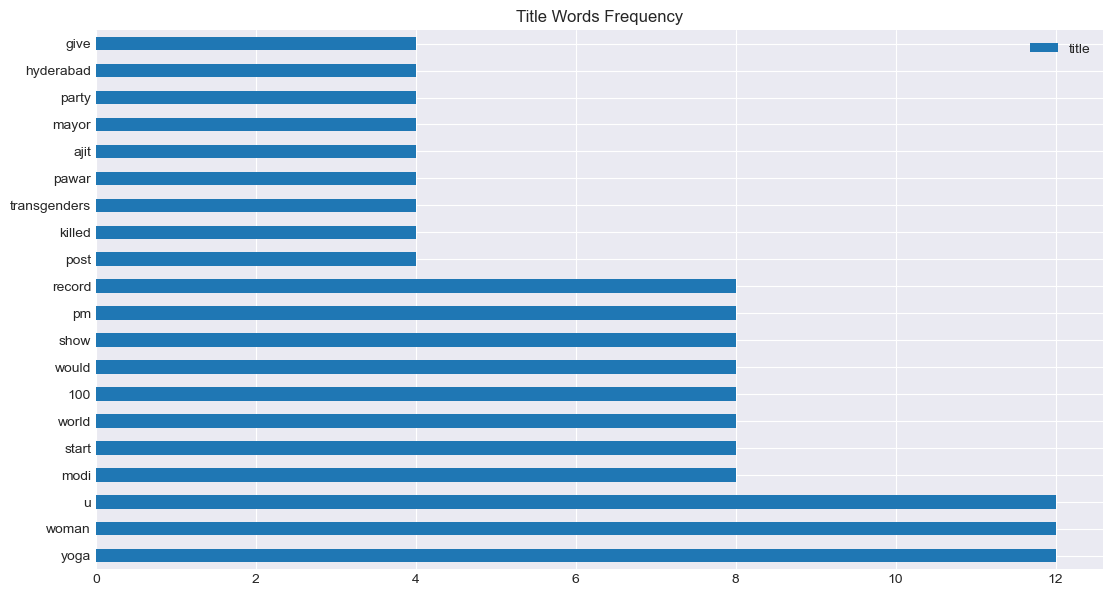

In [119]:
#visualizing the top 20 words sorted on title but only displaying the content column
word_counts.sort_values('title', ascending=False)[['title']].head(20).plot.barh()
plt.title('Title Words Frequency')
plt.show()

In [120]:
#applying a lambda to see the proportion values
word_counts.sort_values('content', ascending=False).head(20).apply(lambda row: row/row['all'], axis=1).round(2)

,category,title,content,all
said,0.0,0.05,0.95,1.0
yoga,0.0,0.23,0.77,1.0
added,0.0,0.00,1.00,1.0
two,0.0,0.00,1.00,1.0
day,0.0,0.14,0.86,1.0
party,0.0,0.17,0.83,1.0
state,0.0,0.00,1.00,1.0
wednesday,0.0,0.00,1.00,1.0
year,0.0,0.00,1.00,1.0
people,0.0,0.17,0.83,1.0


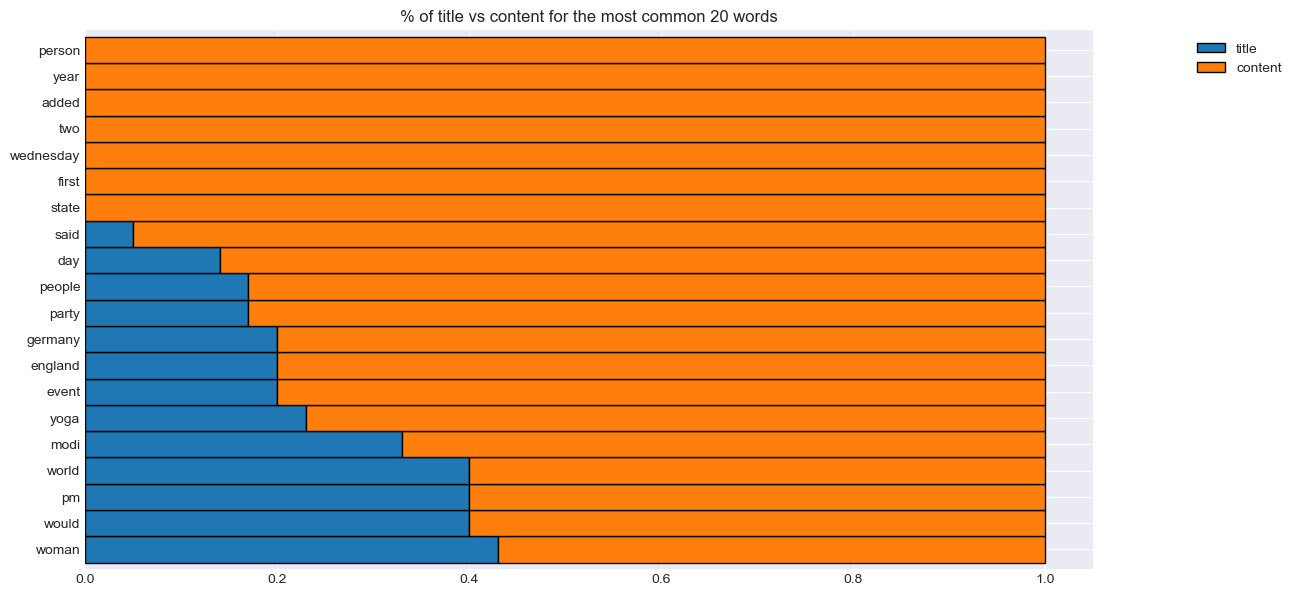

In [123]:
#visualizing the 20 most used words in proportion of words used in title and in content
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis=1).round(2)
 .drop(columns={'all','category'})
 .sort_values('content')
 .plot.barh(stacked=True, width=1, ec='black'))

plt.title('% of title vs content for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

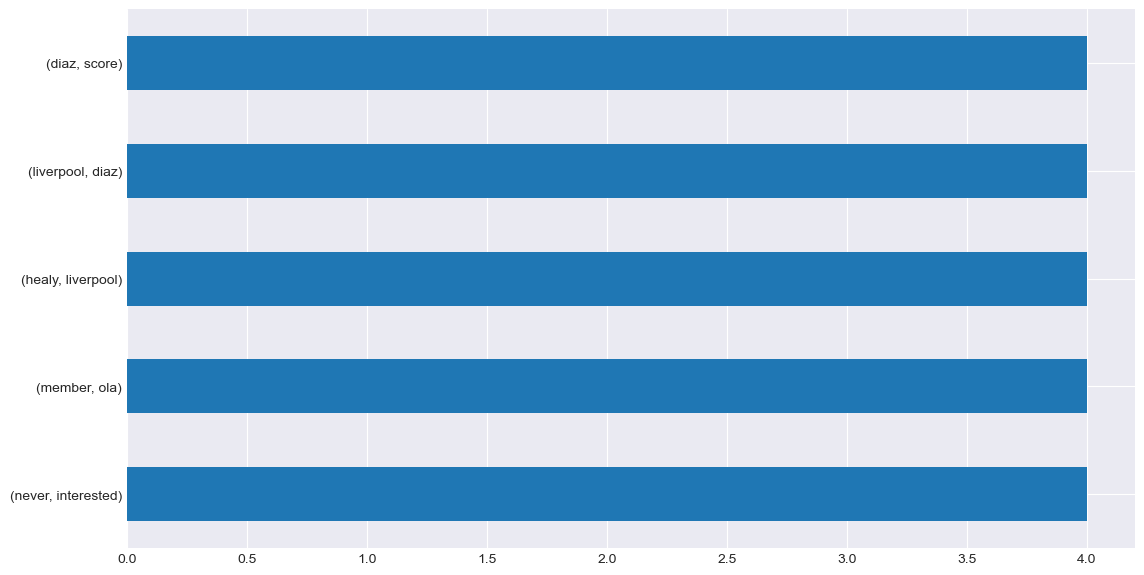

In [124]:
#looking at the bigrams for title words
pd.Series(nltk.bigrams(title_words)).value_counts(ascending=False).head(5).plot.barh();

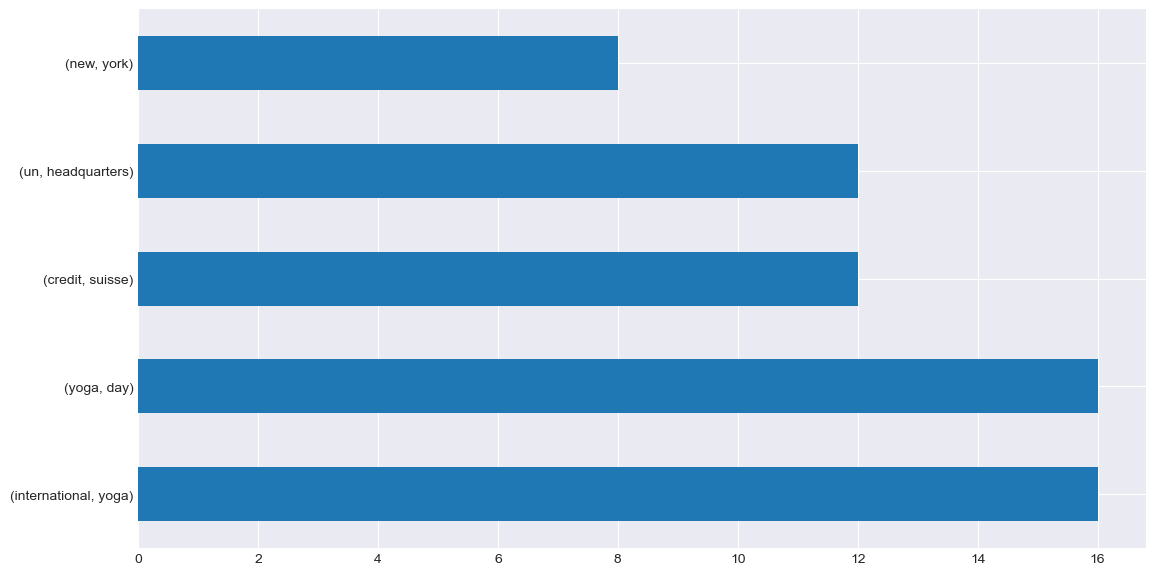

In [125]:
#looking at the bigrams for content words
pd.Series(nltk.bigrams(content_words)).value_counts(ascending=False).head(5).plot.barh();